# Chapter 3 - Computer Vision


### Importing torchvision Libraries


In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(torch.__version__, torchvision.__version__)

2.2.1+cu121 0.17.1+cu121


## 1.Getting a dataset (FashionMNIST)


In [2]:
train_data = datasets.FashionMNIST(
    root="data", train=True, download=False, transform=ToTensor(), target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=False,
    transform=ToTensor(),
    target_transform=None,
)

In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [5]:
image, label = train_data[0]
print(f"{image.shape}->(color_channels,height,width)")
print(f'{label} = class name index, "{class_names[label]}"')

torch.Size([1, 28, 28])->(color_channels,height,width)
9 = class name index, "Ankle boot"


- color channel is 1 because fashionMNIST images are black and white
- 28,28 is height and width


### Visualize the data


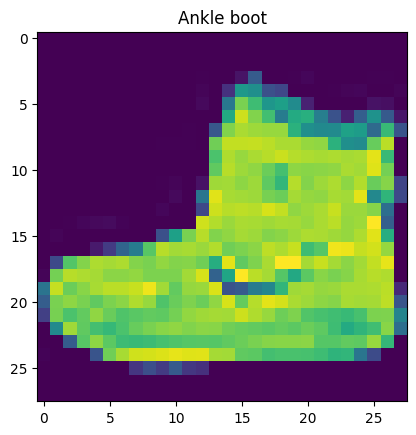

In [6]:
plt.title(class_names[label])
plt.imshow(image.squeeze())
# Matplotlib only accepts image in format Height * Widht * Color(Optional)

(-0.5, 27.5, 27.5, -0.5)

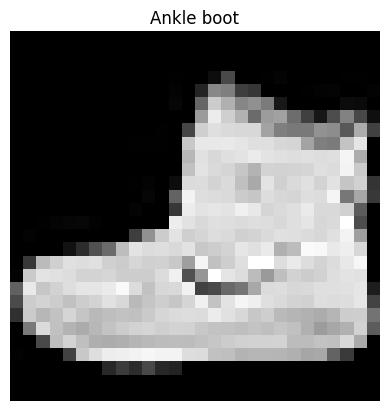

In [7]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

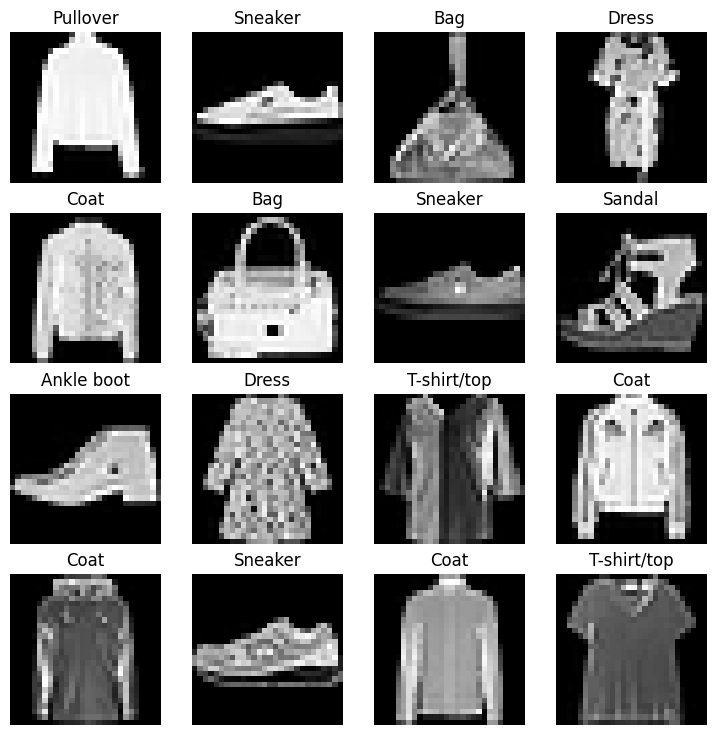

In [8]:
# Plotting more random images
# torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_i = torch.randint(0, len(train_data), size=[1]).item()
    img, lbl = train_data[random_i]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="grey")
    plt.title(class_names[lbl])
    plt.axis(False)

## 2.Preparing Dataloader

- Data loader converts data -> Python iterable
- We need to make data -> mini batches
  - use computer memory efficiently
  - memory can't store thousands/millions of data at once
- Mini-batches give NN better change to update gradients per epoch


In [9]:
from torch.utils.data import DataLoader

BATCH = 32
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH, shuffle=False)

In [10]:
len(train_dataloader), len(test_dataloader)

(1875, 313)

In [11]:
# Whats inside dataloder? (Showing contents of a single batch)
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label:5


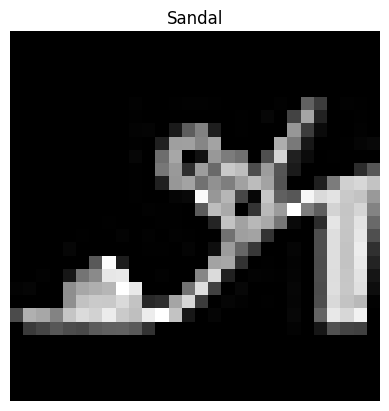

In [12]:
# Selecting a random sample from batch
random_i = torch.randint(low=0, high=len(train_features_batch), size=[1]).item()  # 32
img, label = train_features_batch[random_i], train_labels_batch[random_i]

plt.imshow(img.squeeze(), cmap="grey")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label:{label}")

## 3.Model0: Build a baseline model

- Build simple model first
- Improve it by adding further complexity if it's not doing well


In [13]:
# Creating flatten layer:
flatten = nn.Flatten()

x = train_features_batch[0]  # Single sample
output = flatten(x)

print(f"unflattened: {x.shape}->Color x Height x Width")
print(f"flattened: {output.shape}->Color x Height * Width")

unflattened: torch.Size([1, 28, 28])->Color x Height x Width
flattened: torch.Size([1, 784])->Color x Height * Width


In [14]:
from torch import nn


class FMNISTmodel0(nn.Module):

    def __init__(self, input, hidden, output):
        super().__init__()

        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input, out_features=hidden),
            nn.Linear(in_features=hidden, out_features=output),
        )

    def forward(self, x):

        return self.layer_stack(x)

In [15]:
torch.manual_seed(42)
model0 = FMNISTmodel0(input=784, hidden=10, output=len(class_names))
model0

FMNISTmodel0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [16]:
dummy_x = torch.rand(size=(1, 1, 28, 28))
model0(dummy_x).shape  # Correct logits shape

torch.Size([1, 10])

In [17]:
model0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layer_stack.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.

### Loss function, Optimizer and Metrics


In [18]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model0.parameters(), lr=0.1)

In [49]:
# Timer function
from timeit import default_timer as timer


def print_train_time(start: float, end: float, device):
    time = end - start
    print(f"Training time on {device}: {time:.2f} seconds")
    return time

In [20]:
start_time = timer()
end_time = timer()
print_train_time(start_time, end_time)

Training time: 0.00 seconds


4.419999999072388e-05

### Creating training loop and training batches

- Updating model parameters after batches instead of epochs


In [21]:
from tqdm.auto import tqdm

torch.manual_seed(42)
start_time = timer()

epochs = 3
###Epoch loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}\n-------------------------------")
    ###Training
    train_loss = 0.0
    # Training Batch loop
    for batch, (X, y) in enumerate(train_dataloader):
        model0.train()
        # 1. Forward pass
        y_preds = model0(X)
        # 2. Calculate loss
        loss = loss_fn(y_preds, y)
        train_loss += loss
        # 3.Optimizer zero grad
        optimizer.zero_grad()
        # 4.Backward pass
        loss.backward()
        # 5.Optimizer step
        optimizer.step()
        # Print out what's happening
        if batch % 400 == 0:
            print(f"Looked at {batch*len(X)}/{len(train_dataloader.dataset)} samples")

    # Calculate average loss outside of training loop
    train_loss /= len(train_dataloader)

    ###Testing
    test_loss, test_acc = 0.0, 0.0
    model0.eval()
    with torch.inference_mode():
        # Testing Batch loop
        for X_test, y_test in test_dataloader:
            test_preds = model0(X_test)
            test_loss += loss_fn(test_preds, y_test)
            test_acc += accuracy_fn(y_true=y_test, y_pred=test_preds.argmax(dim=1))

        # Calculate average loss and accuracy outside of test loop
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        # Print out whats happening
        print(
            f"train_loss:{train_loss:.4f} | test_loss:{test_loss:.4f} | test_acc:{test_acc:.4f}"
        )
        print()

end_time = timer()
total_train_time_model0 = print_train_time(start_time, end_time)

c:\Users\nishc\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
-------------------------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 33%|███▎      | 1/3 [00:10<00:20, 10.23s/it]

train_loss:0.5904 | test_loss:0.5095 | test_acc:82.0387

Epoch 1
-------------------------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 67%|██████▋   | 2/3 [00:20<00:10, 10.44s/it]

train_loss:0.4763 | test_loss:0.4799 | test_acc:83.1969

Epoch 2
-------------------------------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 3/3 [00:31<00:00, 10.35s/it]

train_loss:0.4550 | test_loss:0.4766 | test_acc:83.4265

Training time: 31.05 seconds


In [82]:
torch.manual_seed(42)


def eval_model(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device,
):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    loss, acc = 0, 0

    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            loss += loss_fn(preds, y)
            acc += accuracy_fn(y_true=y, y_pred=preds.argmax(dim=1))
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, "loss": loss, "accuracy": acc}

In [23]:
model0_results = eval_model(model0, test_dataloader, loss_fn, accuracy_fn)
model0_results

{'model_name': 'FMNISTmodel0',
 'loss': tensor(0.4766),
 'accuracy': 83.42651757188499}

## 4. Model 1: Adding to baseline model


In [89]:
import torch
import torchvision
from torch import nn

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = "cuda"
device

'cuda'

### Non-linear model


In [90]:
torch.manual_seed(42)


class FMNISTmodel1(nn.Module):

    def __init__(self, input, hidden, output):

        super().__init__()

        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input, out_features=hidden),
            nn.ReLU(),
            nn.Linear(in_features=hidden, out_features=output),
            nn.ReLU(),
            nn.Linear(in_features=hidden, out_features=output),
        )

    def forward(self, x):

        return self.layer_stack(x)

In [91]:
torch.manual_seed(42)
model1 = FMNISTmodel1(input=28 * 28, hidden=10, output=len(class_names)).to(device)
next(model1.parameters()).device

device(type='cuda', index=0)

### Loss function and optimizer, eval metrics


In [92]:
loss_fn1 = nn.CrossEntropyLoss()
optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.1)

### Functionizing training and testing loops


In [93]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    device: torch.device = device,
):
    model.train()

    train_loss, train_acc = 0.0, 0.0

    for X, y in dataloader:

        # Put data into target device

        X, y = X.to(device), y.to(device)

        # 1. Forward pass

        preds = model(X)

        # 2. Calculate loss

        loss = loss_fn(preds, y)

        train_loss += loss

        train_acc += accuracy_fn(y_true=y, y_pred=preds.argmax(dim=1))

        # 3.Optimizer zero grad

        optimizer.zero_grad()

        # 4.Backward pass

        loss.backward()

        # 5.Optimizer step

        optimizer.step()

    # Calculate average loss and accuracy outside of training loop

    train_loss /= len(dataloader)

    train_acc /= len(dataloader)

    print(f"train_loss:{train_loss:.4f} | train_acc:{train_acc:.4f}")

In [94]:
# Functionize testing loop similar to train_step
def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device: torch.device = device,
):
    model.eval()
    test_loss, test_acc = 0.0, 0.0
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            test_loss += loss_fn(preds, y)
            test_acc += accuracy_fn(y_true=y, y_pred=preds.argmax(dim=1))
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
    print(f"test_loss:{test_loss:.4f} | test_acc:{test_acc:.3f}")

In [95]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
start_time = timer()

epochs = 3
###Epoch loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}\n-------------------------------")
    ###Training
    train_step(
        model1,
        train_dataloader,
        loss_fn=loss_fn1,
        optimizer=optimizer1,
        accuracy_fn=accuracy_fn,
        device=device,
    )
    ###Testing
    test_step(model1, test_dataloader, loss_fn1, accuracy_fn, device)

end_time = timer()

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0
-------------------------------
train_loss:0.6677 | train_acc:75.8833


 33%|███▎      | 1/3 [00:15<00:30, 15.42s/it]

test_loss:0.5009 | test_acc:82.089
Epoch 1
-------------------------------
train_loss:0.4834 | train_acc:82.7717


 67%|██████▋   | 2/3 [00:30<00:15, 15.21s/it]

test_loss:0.4890 | test_acc:82.688
Epoch 2
-------------------------------
train_loss:0.4496 | train_acc:83.8733


100%|██████████| 3/3 [00:45<00:00, 15.13s/it]

test_loss:0.4858 | test_acc:82.887


TypeError: print_train_time() missing 1 required positional argument: 'device'

In [96]:
total_train_time_model1 = print_train_time(start_time, end_time, device=device)

Training time on cuda: 45.39 seconds


In [31]:
model1_results = eval_model(model1, test_dataloader, loss_fn1, accuracy_fn)
model1_results

{'model_name': 'FMNISTmodel1',
 'loss': tensor(0.4858),
 'accuracy': 82.8873801916933}

In [32]:
model0_results

{'model_name': 'FMNISTmodel0',
 'loss': tensor(0.4766),
 'accuracy': 83.42651757188499}

## 5.Convolutional Neural Network


In [68]:
class FMNISTmodel2(nn.Module):
    def __init__(self, input: int, hidden: int, output: int):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(
                in_channels=input,
                out_channels=hidden,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden,
                out_channels=hidden,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden,
                out_channels=hidden,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden,
                out_channels=hidden,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden * 7 * 7, out_features=output),
        )

    def forward(self, x):
        x = self.conv_block(x)
        # print(f"output shape of conv block1: {x.shape}")
        x = self.conv_block2(x)
        # print(f"output shape of conv block2: {x.shape}")
        x = self.classifier(x)
        # print(f"output shape of classifier block2: {x.shape}")

        return x

### Create model and select device


In [76]:
device = "cuda"
torch.manual_seed(42)
model2 = FMNISTmodel2(input=1, hidden=10, output=len(class_names)).to(device)

In [77]:
next(model2.parameters()).device

device(type='cuda', index=0)

#### Using dummy tensor to check input shape of classifier layer


In [71]:
torch.manual_seed(42)
rand_image = torch.randn(size=(1, 28, 28))

In [72]:
rand_output = model2(rand_image.unsqueeze(0).to(device))
rand_output

tensor([[ 0.0505, -0.0729,  0.0821, -0.0451, -0.0044,  0.0383,  0.0061, -0.0016,
         -0.0127, -0.0081]], grad_fn=<AddmmBackward0>)

### Stepping through Conv2d


In [62]:
torch.manual_seed(42)
images_dummy = torch.randn(size=(32, 3, 64, 64))
test_image = images_dummy[0]
test_image.shape

torch.Size([3, 64, 64])

In [63]:
# Test convolution layer
torch.manual_seed(42)
conv_layer = nn.Sequential(
    nn.Conv2d(
        in_channels=3,
        out_channels=10,
        kernel_size=3,
        stride=1,
        padding=0,
    )
)

# Passing image tensor through conv data
conv_output = conv_layer(test_image)
conv_output.shape

torch.Size([10, 62, 62])

### Stepping through MaxPool2D


In [64]:
print(f"Test image original shape:{test_image.shape}")
maxpool_layer = nn.MaxPool2d(kernel_size=2)
print(
    f"Test image through maxpool: {maxpool_layer(test_image).shape}"
)  # ->Takes maximum activation from a kernel
print(
    f"Test image through conv layer: {conv_output.shape}"
)  # ->Takes maximum activation from a kernel

print(f"Test image through conv and maxpool: {maxpool_layer(conv_output).shape}")

Test image original shape:torch.Size([3, 64, 64])
Test image through maxpool: torch.Size([3, 32, 32])
Test image through conv layer: torch.Size([10, 62, 62])
Test image through conv and maxpool: torch.Size([10, 31, 31])


### Loss function, Optimizer and Eval metrics


In [73]:
from helper_functions import accuracy_fn

In [78]:
loss_fn2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.SGD(params=model2.parameters(), lr=0.1)

### Training and Testing CNN


In [88]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measuring time
from timeit import default_timer as timer

train_time_start_model2 = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n----------")
    train_step(
        model=model2,
        dataloader=train_dataloader,
        loss_fn=loss_fn2,
        optimizer=optimizer2,
        accuracy_fn=accuracy_fn,
        device=device,
    )
    test_step(
        model=model2,
        dataloader=test_dataloader,
        loss_fn=loss_fn2,
        accuracy_fn=accuracy_fn,
        device=device,
    )
train_time_end_model2 = timer()
total_train_time_model2 = print_train_time(
    start=train_time_start_model2,
    end=train_time_end_model2,
    device=device,
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
----------
train_loss:0.3033 | train_acc:89.1450


 33%|███▎      | 1/3 [00:18<00:36, 18.30s/it]

test_loss:0.3122 | test_acc:88.668
Epoch: 1
----------
train_loss:0.2898 | train_acc:89.5200


 67%|██████▋   | 2/3 [00:36<00:18, 18.34s/it]

test_loss:0.3079 | test_acc:88.448
Epoch: 2
----------
train_loss:0.2781 | train_acc:89.8800


100%|██████████| 3/3 [00:53<00:00, 17.92s/it]

test_loss:0.3136 | test_acc:88.478
Training time on cuda: 53.75 seconds


In [85]:
model2_results = eval_model(
    model=model2,
    data_loader=test_dataloader,
    loss_fn=loss_fn2,
    accuracy_fn=accuracy_fn,
    device=device,
)
model2_results

{'model_name': 'FMNISTmodel2',
 'loss': tensor(0.3400, device='cuda:0'),
 'accuracy': 87.88937699680511}

## 8.Comparing Model Results


In [103]:
import pandas as pd

compare_results = pd.DataFrame([model0_results, model1_results, model2_results])
compare_results

,model_name,loss,accuracy
0,FMNISTmodel0,tensor(0.4766),83.426518
1,FMNISTmodel1,tensor(0.4858),82.887380
2,FMNISTmodel2,"tensor(0.3400, device='cuda:0')",87.889377


In [105]:
# Adding training time to dataframe
compare_results["training time"] = [
    total_train_time_model0,
    total_train_time_model1,
    total_train_time_model2,
]
compare_results

,model_name,loss,accuracy,training time
0,FMNISTmodel0,tensor(0.4766),83.426518,30.622779
1,FMNISTmodel1,tensor(0.4858),82.887380,45.392346
2,FMNISTmodel2,"tensor(0.3400, device='cuda:0')",87.889377,53.754747
